In [13]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from scipy.misc import imread
import matplotlib.image as mpimg

def getCameraCalibrationMatrix(img):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret != True:
        print('Loading calibration image error')
        raise

    objpoints.append(objp)
    imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

def getPerspectiveMatrixes(w, h):
    srcPoints = np.float32(
        [[w * 0.18, h * 0.95],
         [w * 0.457, h * 0.63],
         [w * 0.543, h * 0.63],
         [w * 0.82, h * 0.95]])
    dstPoints = np.float32(
        [[w * 0.25, h],
         [w * 0.25, 0],
         [w * 0.75, 0],
         [w * 0.75, h]])
    
    M = cv2.getPerspectiveTransform(srcPoints, dstPoints)
    Minv = cv2.getPerspectiveTransform(dstPoints, srcPoints)

    return M, Minv

def warpImage(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)  # keep same size as input image
    return warped

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def binaryImage(img, thresh=(110, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    sumImg = np.maximum.reduce([adjust_gamma(L, 0.3),S])
    
    binary = np.zeros_like(sumImg)
    binary[(sumImg >= thresh[0]) & (sumImg <= thresh[1])] = 1

    return binary


def find_window_centroids(image, window_width = 50, window_height = 80, margin = 100):
    leftx = []
    rightx = []
    ploty = np.linspace(0, 719, int(720 / window_height))
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    leftx.append(l_center)
    rightx.append(r_center)

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        leftx.append(l_center)
        rightx.append(r_center)
    
    leftx = leftx[::-1]
    rightx = rightx[::-1]

    return (leftx, ploty, rightx, ploty)

def find_window_centroids2(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return (left_fitx, ploty, right_fitx, ploty, left_fit, right_fit)

def drawCentroids(img, leftx, lefty, rightx, righty, window_height = 80):

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

    left_points = np.vstack(([left_fitx.T], [lefty.T])).T
    right_points = np.vstack(([right_fitx.T], [righty.T])).T
    all_points = np.concatenate((left_points, right_points[::-1]))

    cv2.fillConvexPoly(img, np.int32([all_points]), (0, 255, 0))

    cv2.polylines(img, np.int32([left_points]), False, (255, 0, 0), 20)
    cv2.polylines(img, np.int32([right_points]), False, (255, 0, 0), 20)
        
    return img

def getCurvature(ploty, leftx, lefty, rightx, righty, left_fit, right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return (left_curverad, right_curverad)

def getCenter(leftx, rightx):
    left = leftx[len(leftx) - 1]
    right = rightx[len(rightx) - 1]
    center = (left + right) / 2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (1280/2 - center)*xm_per_pix

def processImage(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped = warpImage(undist, M)
    binary = binaryImage(warped)
    leftx, lefty, rightx, righty, left_fit, right_fit = find_window_centroids2(binary)
    highlight_warped = drawCentroids(np.zeros_like(warped), leftx, lefty, rightx, righty)
    highlight = warpImage(highlight_warped, Minv)
    output = cv2.addWeighted(undist, 1, highlight, 0.3, 0.0)
    
    left_curverad, right_curverad = getCurvature(lefty, leftx, lefty, rightx, righty, left_fit, right_fit)
    curvature = min([left_curverad, right_curverad])
    
    text = "Curvature: {} m".format(int(curvature))
    cv2.putText(output, text, (450,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    pos = getCenter(leftx, rightx)
    if pos < 0:
        text = "Vehicle is {:.2f} m left".format(-pos)
    else:
        text = "Vehicle is {:.2f} m right".format(pos)
    cv2.putText(output, text, (420,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    return output

# init
mtx, dist = getCameraCalibrationMatrix(cv2.imread('camera_cal/calibration2.jpg'))
M, Minv = getPerspectiveMatrixes(1280, 720)

print("Camera calibration matrix:", mtx)


Camera calibration matrix: [[ 872.5223319     0.          649.38554509]
 [   0.          853.10470045  213.74930061]
 [   0.            0.            1.        ]]


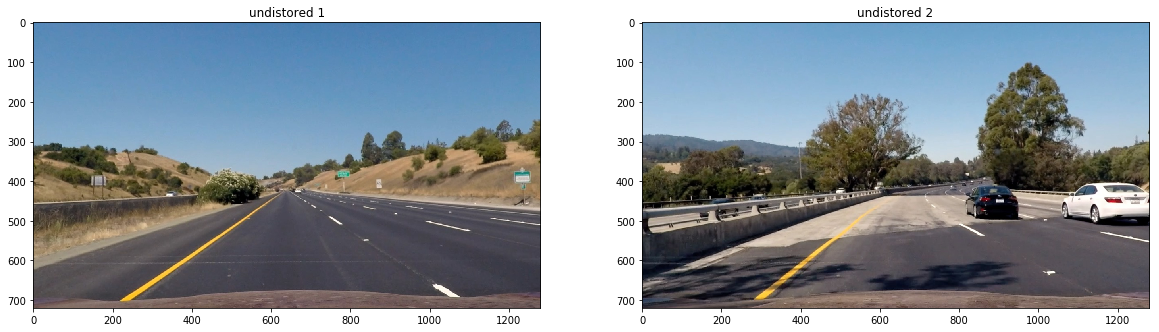

In [8]:
in_image1 = cv2.cvtColor(cv2.imread("test_images/straight_lines1.jpg"), cv2.COLOR_BGR2RGB)
undist1 = cv2.undistort(in_image1, mtx, dist, None, mtx)

in_image2 = cv2.cvtColor(cv2.imread("test_images/test4.jpg"), cv2.COLOR_BGR2RGB)
undist2 = cv2.undistort(in_image2, mtx, dist, None, mtx)

plt.rcParams["figure.figsize"] = [20, 15]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('undistored 1')
ax1.imshow(undist1)

ax2.set_title('undistored 2')
ax2.imshow(undist2)

plt.show()

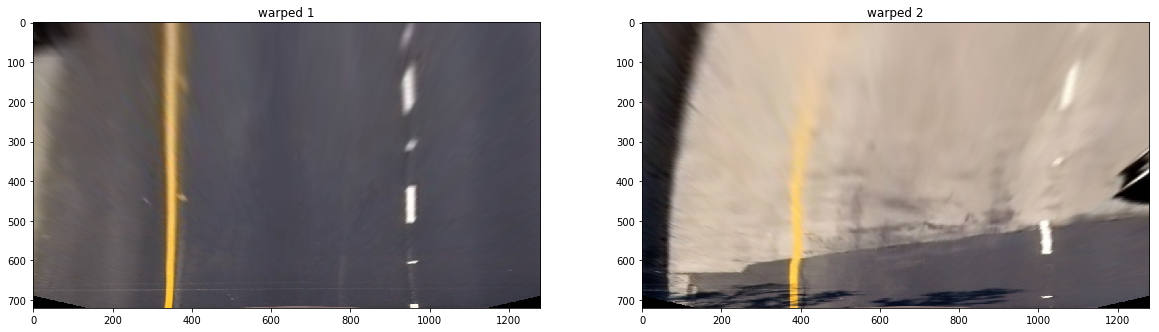

In [9]:
warped1 = warpImage(undist1, M)
warped2 = warpImage(undist2, M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('warped 1')
ax1.imshow(warped1)

ax2.set_title('warped 2')
ax2.imshow(warped2)

plt.show()

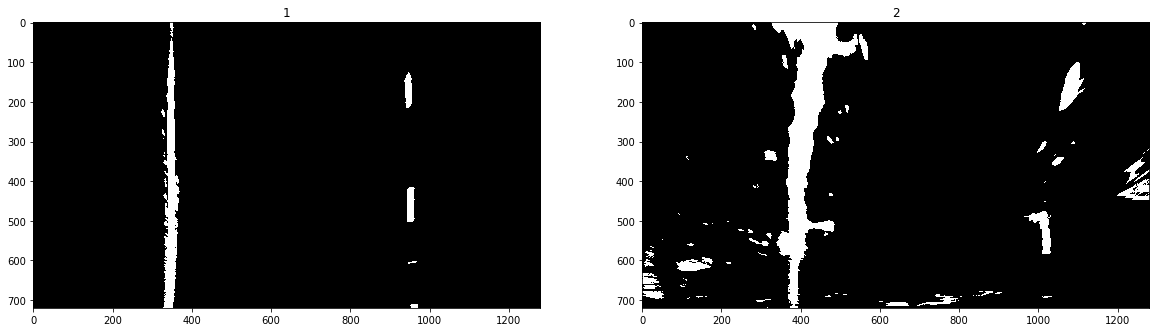

In [10]:
binary1 = binaryImage(warped1)
binary2 = binaryImage(warped2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('1')
ax1.imshow(binary1, cmap='gray')

ax2.set_title('2')
ax2.imshow(binary2, cmap='gray')

plt.show()

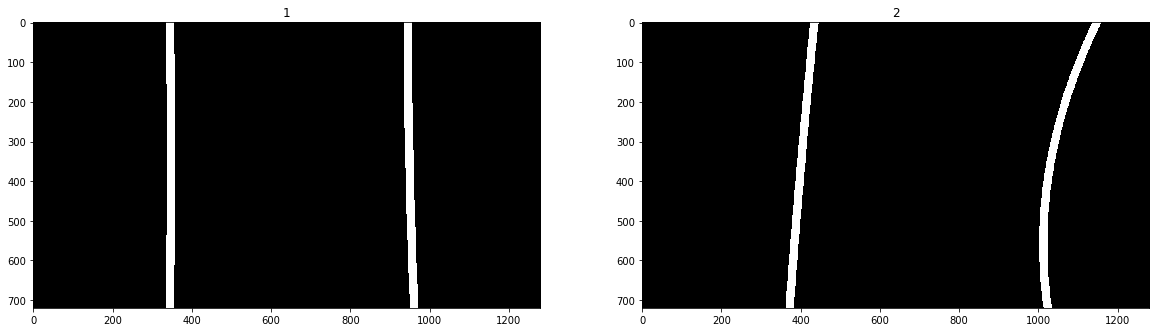

In [11]:
leftx1, lefty1, rightx1, righty1, left_fit1, right_fit1 = find_window_centroids2(binary1)
centroidBlocks1 = drawCentroids(np.zeros_like(binary1), leftx1, lefty1, rightx1, righty1)

leftx2, lefty2, rightx2, righty2, left_fit2, right_fit2 = find_window_centroids2(binary2)
centroidBlocks2 = drawCentroids(np.zeros_like(binary2), leftx2, lefty2, rightx2, righty2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('1')
ax1.imshow(centroidBlocks1, cmap='gray')

ax2.set_title('2')
ax2.imshow(centroidBlocks2, cmap='gray')

plt.show()

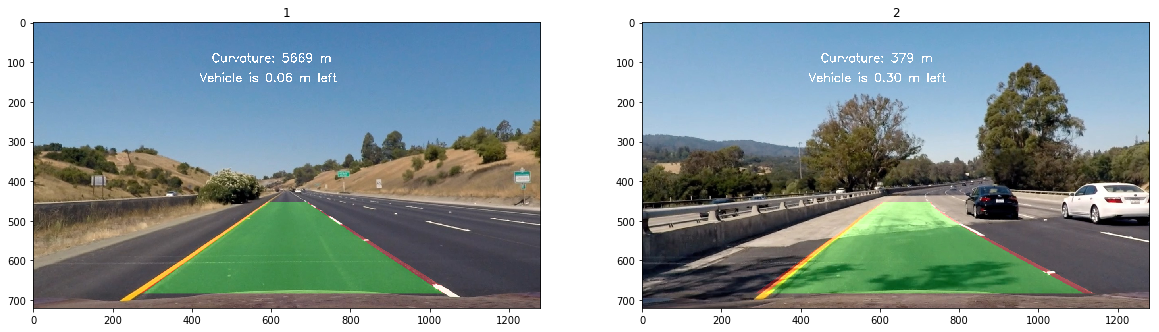

In [14]:
out_image1 = processImage(in_image1)
out_image2 = processImage(in_image2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('1')
ax1.imshow(out_image1)

ax2.set_title('2')
ax2.imshow(out_image2)

plt.show()

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(0, 2)
white_clip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:52<00:00, 11.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 

Wall time: 1min 53s
